In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from scripts import *

In [2]:
%store -r df_merged
df_merged

,T,T_a,DD,Ff,N,Nh,Cl,Po,U,Ch,...,RRR,DD_,diff,abs_diff,T_kal,T_sher,T_sar,three_mean,diff_3,abs_diff_3
2012-11-01 00:00:00,-1.9,-6.0,"Ветер, дующий с северо-запада",3.0,0.0,NaN,NaN,763.7,75.0,NaN,...,NaN,North,4.1,4.1,-4.8,-4.0,-4.0,-4.266667,2.366667,2.366667
2012-11-01 03:00:00,-3.7,-7.0,"Ветер, дующий с северо-запада",2.0,10.0,10.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",764.9,83.0,"Перистых, перисто-кучевых или перисто-слоистых...",...,NaN,North,3.3,3.3,-5.4,-5.8,-4.7,-5.300000,1.600000,1.600000
2012-11-01 06:00:00,-5.1,-7.0,"Ветер, дующий с северо-запада",1.0,100.0,0.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",766.4,90.0,"Перистые нитевидные, иногда когтевидные, не ра...",...,NaN,North,1.9,1.9,-6.9,-6.4,-7.5,-6.933333,1.833333,1.833333
2012-11-01 09:00:00,-6.6,-8.0,"Ветер, дующий с северо-северо-запада",1.0,0.0,NaN,NaN,767.6,94.0,NaN,...,Осадков нет,North,1.4,1.4,-6.9,-7.6,-8.1,-7.533333,0.933333,0.933333
2012-11-01 12:00:00,0.9,0.0,"Ветер, дующий с юго-запада",1.0,100.0,0.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",768.6,64.0,"Перисто-кучевые одни или перисто-кучевые, сопр...",...,NaN,West,0.9,0.9,0.0,-0.4,0.0,-0.133333,1.033333,1.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 09:00:00,-25.8,-24.0,"Ветер, дующий с востока",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",755.8,79.0,NaN,...,Следы осадков,East,-1.8,1.8,-26.5,-22.8,-27.2,-25.500000,-0.300000,0.300000
2021-02-28 12:00:00,-20.7,-20.0,"Ветер, дующий с востока",4.0,100.0,0.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",753.9,81.0,Перистые (часто в виде полос) и перисто-слоист...,...,NaN,East,-0.7,0.7,-20.9,-20.4,-21.1,-20.800000,0.100000,0.100000
2021-02-28 15:00:00,-17.2,-17.0,"Ветер, дующий с востока",5.0,100.0,40.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",751.9,80.0,Перистые (часто в виде полос) и перисто-слоист...,...,NaN,East,-0.2,0.2,-17.3,-16.4,-16.4,-16.700000,-0.500000,0.500000
2021-02-28 18:00:00,-17.3,-17.0,"Ветер, дующий с востока",6.0,100.0,100.0,Кучево-дождевые волокнистые (часто с наковальн...,750.1,82.0,NaN,...,NaN,East,-0.3,0.3,-17.6,-16.0,-16.9,-16.833333,-0.466667,0.466667


### предсказание разницы температуры

In [404]:
df_merged_c = df_merged.copy()
df_merged_c = df_merged_c[df_merged_c['abs_diff'] > 1]

In [405]:
# try catboost reg
# df_merged_c = df_merged.copy()

df_merged_c['Cl'] = df_merged_c['Cl'].fillna(0)
df_merged_c['Ch'] = df_merged_c['Ch'].fillna(0)
df_merged_c['Cm'] = df_merged_c['Cm'].fillna(0)
df_merged_c['H'] = df_merged_c['H'].fillna(0)
df_merged_c['RRR'] = df_merged_c['RRR'].fillna(0)

In [6]:
# train_data = df_merged_c['2012':'2019-03']
# train_data = train_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])
# eval_data = df_merged_c['2019-11':]
# eval_data = eval_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])
# train_labels = df_merged_c['2012':'2019-03']['diff']

In [406]:
train_data = df_merged_c['2012':'2019-03']
train_data = train_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a', 'T_kal', 'T_sher', 'T_sar', 'three_mean'])
eval_data = df_merged_c['2019-11':]
eval_data = eval_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a', 'T_kal', 'T_sher', 'T_sar', 'three_mean'])
train_labels = df_merged_c['2012':'2019-03']['diff']

In [407]:
model = CatBoostRegressor(iterations=1000, # {'depth': 10, 'l2_leaf_reg': 5, 'iterations': 1000, 'learning_rate': 0.3}
                           task_type="GPU",
                           devices='0:1',
                         depth=10,
                         l2_leaf_reg=5,
                         learning_rate=0.3)
cat_cols = ['DD, ''DD_', 'Cl', 'Cm','Ch', 'H', 'RRR']

model.fit(train_data,
          train_labels,
          verbose=False,
         cat_features=cat_cols)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="Ветер, дующий с северо-запада": Cannot convert 'b'\xd0\x92\xd0\xb5\xd1\x82\xd0\xb5\xd1\x80, \xd0\xb4\xd1\x83\xd1\x8e\xd1\x89\xd0\xb8\xd0\xb9 \xd1\x81 \xd1\x81\xd0\xb5\xd0\xb2\xd0\xb5\xd1\x80\xd0\xbe-\xd0\xb7\xd0\xb0\xd0\xbf\xd0\xb0\xd0\xb4\xd0\xb0'' to float

In [158]:
# Перебор параметров
# from catboost import CatBoost

# params = {'depth':[6,4,7,10],
#               'iterations':[250,100,500,1000],
#               'learning_rate':[0.03,0.1,0.2,0.3],
#               'l2_leaf_reg':[3,1,5,10]}

# model2 = CatBoostRegressor(cat_features=cat_cols, task_type="GPU",
#                            devices='0:1')

# found_parameters = model2.grid_search(params,
#                                            X=train_data,
#                                            y=train_labels,
#                                            cv=3,
#                                            partition_random_seed=3,
#                                            stratified=True,
#                                        )

# print(found_parameters['params'])

bestTest = 1.074941674
bestIteration = 249
0:	loss: 1.0749417	best: 1.0749417 (0)	total: 8.53s	remaining: 36m 15s
bestTest = 1.022736106
bestIteration = 249
1:	loss: 1.0227361	best: 1.0227361 (1)	total: 14.7s	remaining: 31m 9s
bestTest = 1.000301691
bestIteration = 243
2:	loss: 1.0003017	best: 1.0003017 (2)	total: 20.7s	remaining: 29m 7s
bestTest = 1.001963945
bestIteration = 247
3:	loss: 1.0019639	best: 1.0003017 (2)	total: 26.9s	remaining: 28m 17s
bestTest = 1.072310364
bestIteration = 249
4:	loss: 1.0723104	best: 1.0003017 (2)	total: 33.6s	remaining: 28m 7s
bestTest = 1.022409145
bestIteration = 249
5:	loss: 1.0224091	best: 1.0003017 (2)	total: 39.3s	remaining: 27m 19s
bestTest = 1.007378621
bestIteration = 249
6:	loss: 1.0073786	best: 1.0003017 (2)	total: 44.4s	remaining: 26m 20s
bestTest = 0.9940769059
bestIteration = 249
7:	loss: 0.9940769	best: 0.9940769 (7)	total: 49.7s	remaining: 25m 40s
bestTest = 1.071503226
bestIteration = 249
8:	loss: 1.0715032	best: 0.9940769 (7)	total: 5

bestTest = 0.9994035944
bestIteration = 218
71:	loss: 0.9994036	best: 0.9640374 (55)	total: 13m 3s	remaining: 33m 23s
bestTest = 1.070380427
bestIteration = 249
72:	loss: 1.0703804	best: 0.9640374 (55)	total: 13m 9s	remaining: 32m 58s
bestTest = 1.019681134
bestIteration = 248
73:	loss: 1.0196811	best: 0.9640374 (55)	total: 13m 14s	remaining: 32m 34s
bestTest = 1.000521941
bestIteration = 241
74:	loss: 1.0005219	best: 0.9640374 (55)	total: 13m 19s	remaining: 32m 9s
bestTest = 0.9929275621
bestIteration = 220
75:	loss: 0.9929276	best: 0.9640374 (55)	total: 13m 24s	remaining: 31m 45s
bestTest = 1.069547051
bestIteration = 249
76:	loss: 1.0695471	best: 0.9640374 (55)	total: 13m 29s	remaining: 31m 22s
bestTest = 1.023599261
bestIteration = 248
77:	loss: 1.0235993	best: 0.9640374 (55)	total: 13m 34s	remaining: 30m 58s
bestTest = 0.9982997504
bestIteration = 248
78:	loss: 0.9982998	best: 0.9640374 (55)	total: 13m 39s	remaining: 30m 36s
bestTest = 1.005085636
bestIteration = 242
79:	loss: 1.0

bestTest = 1.020700983
bestIteration = 248
141:	loss: 1.0207010	best: 0.9627178 (127)	total: 23m 4s	remaining: 18m 31s
bestTest = 0.9991988391
bestIteration = 249
142:	loss: 0.9991988	best: 0.9627178 (127)	total: 23m 10s	remaining: 18m 18s
bestTest = 0.9966399895
bestIteration = 246
143:	loss: 0.9966400	best: 0.9627178 (127)	total: 23m 15s	remaining: 18m 5s
bestTest = 1.085597155
bestIteration = 99
144:	loss: 1.0855972	best: 0.9627178 (127)	total: 23m 17s	remaining: 17m 49s
bestTest = 1.020603083
bestIteration = 99
145:	loss: 1.0206031	best: 0.9627178 (127)	total: 23m 19s	remaining: 17m 34s
bestTest = 1.000196293
bestIteration = 99
146:	loss: 1.0001963	best: 0.9627178 (127)	total: 23m 21s	remaining: 17m 18s
bestTest = 0.991084063
bestIteration = 99
147:	loss: 0.9910841	best: 0.9627178 (127)	total: 23m 22s	remaining: 17m 3s
bestTest = 1.080481427
bestIteration = 99
148:	loss: 1.0804814	best: 0.9627178 (127)	total: 23m 24s	remaining: 16m 48s
bestTest = 1.017026788
bestIteration = 97
149:

bestTest = 1.001452142
bestIteration = 97
210:	loss: 1.0014521	best: 0.9627178 (127)	total: 35m 56s	remaining: 7m 39s
bestTest = 0.9881312088
bestIteration = 97
211:	loss: 0.9881312	best: 0.9627178 (127)	total: 35m 59s	remaining: 7m 28s
bestTest = 1.082967642
bestIteration = 99
212:	loss: 1.0829676	best: 0.9627178 (127)	total: 36m 2s	remaining: 7m 16s
bestTest = 1.019464169
bestIteration = 99
213:	loss: 1.0194642	best: 0.9627178 (127)	total: 36m 5s	remaining: 7m 4s
bestTest = 0.9971059742
bestIteration = 99
214:	loss: 0.9971060	best: 0.9627178 (127)	total: 36m 8s	remaining: 6m 53s
bestTest = 0.9815127867
bestIteration = 99
215:	loss: 0.9815128	best: 0.9627178 (127)	total: 36m 11s	remaining: 6m 42s
bestTest = 1.090091536
bestIteration = 99
216:	loss: 1.0900915	best: 0.9627178 (127)	total: 36m 14s	remaining: 6m 30s
bestTest = 1.026882494
bestIteration = 99
217:	loss: 1.0268825	best: 0.9627178 (127)	total: 36m 18s	remaining: 6m 19s
bestTest = 0.997044668
bestIteration = 99
218:	loss: 0.99

{'depth': 10, 'l2_leaf_reg': 5, 'iterations': 1000, 'learning_rate': 0.3}


In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2134 entries, 2012-11-01 00:00:00 to 2019-02-28 21:00:00
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       2134 non-null   float64
 1   Ff      2134 non-null   float64
 2   N       2132 non-null   float64
 3   Nh      1327 non-null   float64
 4   Cl      2134 non-null   int32  
 5   Po      2134 non-null   float64
 6   U       2131 non-null   float64
 7   Ch      2134 non-null   object 
 8   Cm      2134 non-null   object 
 9   H       2134 non-null   object 
 10  RRR     2134 non-null   object 
 11  DD_     2134 non-null   object 
dtypes: float64(6), int32(1), object(5)
memory usage: 208.4+ KB


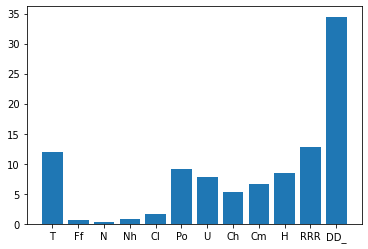

In [20]:
# plt.bar([0,1,2,3,4,5,6,7,8,9, 10, 11,12,13,14, 15], model.get_feature_importance())
# plt.bar([0,1,2,3,4,5,6,7,8,9, 10, 11], model.get_feature_importance())
plt.bar(train_data.columns, model.get_feature_importance())
plt.show()

In [94]:
def mape_vectorized_v2(x):
    a = x['diff']
    b = x['diff_p']
    mask = a != 0
    return (np.fabs((a - b))/a)[mask].mean()

def mean_absolute_percentage_error(x):
    y_true = x['diff']
    y_pred = x['diff_p']
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
eps = 1e-6
preds = model.predict(eval_data)
df_merged_w_preds = df_merged_c['2019-11':].copy()
df_merged_w_preds['diff_p'] = pd.Series(preds, index=df_merged_w_preds.index)
df_merged_w_preds['error'] = abs(df_merged_w_preds['diff'] - df_merged_w_preds['diff_p'])
df_merged_w_preds['error rel'] = abs(df_merged_w_preds['error']/df_merged_w_preds['diff'] + 1e-6)
df_merged_w_preds['error rel lg'] = np.log(abs(df_merged_w_preds['error']/df_merged_w_preds['diff'] + 1e-6)*10 +1)
df_merged_w_preds['mape'] = df_merged_w_preds.apply(mean_absolute_percentage_error, axis=1)
df_merged_w_preds[['diff', 'diff_p', 'error', 'error rel', 'error rel lg']]

,diff,diff_p,error,error rel,error rel lg
2019-11-01 09:00:00,1.2,2.714525,1.514525,1.262106,2.611617
2019-11-03 00:00:00,1.1,2.331392,1.231392,1.119448,2.500984
2019-11-03 12:00:00,-1.1,1.620220,2.720220,2.472927,3.247629
2019-11-04 00:00:00,-2.3,-0.194461,2.105539,0.915451,2.317918
2019-11-04 09:00:00,-1.1,-0.198489,0.901511,0.819555,2.218719
...,...,...,...,...,...
2021-02-27 15:00:00,1.5,2.449273,0.949273,0.632850,1.991770
2021-02-27 18:00:00,-1.9,1.158860,3.058860,1.609925,2.839035
2021-02-27 21:00:00,1.1,1.158860,0.058860,0.053510,0.428595
2021-02-28 03:00:00,-2.6,-2.230619,0.369381,0.142069,0.884051


In [35]:
df_merged_w_preds[df_merged_w_preds['error rel'] > 1][['diff', 'diff_p', 'error', 'error rel', 'mape', 'error rel lg']]

,diff,diff_p,error,error rel,mape,error rel lg
2019-11-01 09:00:00,1.2,2.714525,1.514525,1.262106,126.210453,2.611617
2019-11-03 00:00:00,1.1,2.331392,1.231392,1.119448,111.944720,2.500984
2019-11-03 12:00:00,-1.1,1.620220,2.720220,2.472927,247.292773,3.247629
2019-11-05 03:00:00,-2.4,0.523552,2.923552,1.218146,121.814684,2.578811
2019-11-05 06:00:00,-3.3,0.388113,3.688113,1.117609,111.760985,2.499474
...,...,...,...,...,...,...
2021-02-04 15:00:00,3.4,-0.520500,3.920500,1.153089,115.308832,2.528197
2021-02-08 12:00:00,1.2,-1.457501,2.657501,2.214585,221.458425,3.141816
2021-02-11 03:00:00,-2.5,1.681240,4.181240,1.672495,167.249603,2.874973
2021-02-20 03:00:00,-2.4,1.472930,3.872930,1.613720,161.372095,2.841252


In [93]:
df_merged_w_preds['error rel'].mean()

inf

In [403]:
df_merged_w_preds['error'].mean()

NameError: name 'df_merged_w_preds' is not defined

In [38]:
abs(df_merged_w_preds['diff']).mean()

1.8663883089770361

In [17]:
df_merged_w_preds['error'][df_merged_w_preds['abs_diff'] > 2].mean()

1.8831462500502412

In [214]:
abs(df_merged_w_preds['diff'][df_merged_w_preds['abs_diff'] > 2]).mean()

2.827210884353741

In [215]:
abs(df_merged_w_preds['diff'][df_merged_w_preds['abs_diff'] > 2]).var()

0.7432270990588015

In [132]:
df_merged_w_preds['true_preds'] = df_merged_w_preds['error'] < 0.5

In [133]:
idxs = df_merged_w_preds[df_merged_w_preds['true_preds']].index.values
test_slice = eval_data.loc[idxs]
test_slice_labels = df_merged_w_preds[df_merged_w_preds['true_preds']]['diff']

In [134]:
test_slice = Pool(data=test_slice, label=test_slice_labels, cat_features=cat_cols)

In [135]:
prediction_diff = model.get_feature_importance(type='LossFunctionChange', data=test_slice, prettified=True)
prediction_diff['perc'] = prediction_diff.iloc[:,1] / prediction_diff.iloc[0,1] * 100
prediction_diff.head(10)

,Feature Id,Importances,perc
0,T,0.365873,100.000000
1,T_sher,0.207352,56.673302
2,T_kal,0.134174,36.672270
3,T_sar,0.047298,12.927322
4,DD_,0.042744,11.682837
5,Nh,0.028349,7.748361
6,Po,0.019039,5.203723
7,N,0.015737,4.301335
8,three_mean,0.004747,1.297574
9,Ff,0.003248,0.887621


Возьмем выборку с большой разностью:

In [217]:
#
# try catboost reg
train_data = df_merged_c['2012':'2019-03'][df_merged_c['abs_diff'] > 1.9]
train_data = train_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])
eval_data = df_merged_c['2019-11':]
eval_data = eval_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])
train_labels = df_merged_c['2012':'2019-03'][df_merged_c['abs_diff'] > 1.9]['diff']

C:\Users\Dima\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dima\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [220]:
model = CatBoostRegressor(iterations=1000, 
                           task_type="GPU",
                           devices='0:1')

model.fit(train_data,
          train_labels,
          verbose=False,
         cat_features=cat_cols)

In [221]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 832 entries, 2012-11-01 00:00:00 to 2019-02-28 15:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T           832 non-null    float64
 1   Ff          832 non-null    float64
 2   N           832 non-null    float64
 3   Nh          454 non-null    float64
 4   Cl          832 non-null    int32  
 5   Po          832 non-null    float64
 6   U           831 non-null    float64
 7   Ch          832 non-null    object 
 8   Cm          832 non-null    object 
 9   H           832 non-null    object 
 10  RRR         832 non-null    object 
 11  DD_         832 non-null    object 
 12  T_kal       831 non-null    float64
 13  T_sher      832 non-null    float64
 14  T_sar       637 non-null    float64
 15  three_mean  636 non-null    float64
dtypes: float64(10), int32(1), object(5)
memory usage: 107.2+ KB


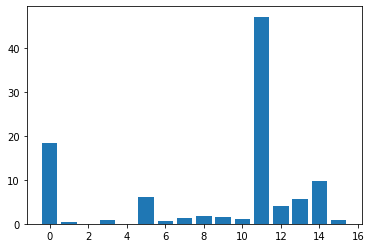

In [223]:
plt.bar([0,1,2,3,4,5,6,7,8,9, 10, 11, 12, 13, 14, 15],model.get_feature_importance())
plt.show()

In [83]:
preds = model.predict(eval_data)
df_merged_w_preds = df_merged['2019-11':].copy()
df_merged_w_preds['diff_p'] = pd.Series(preds, index=df_merged_w_preds.index)
df_merged_w_preds['error'] = abs(df_merged_w_preds['diff'] - df_merged_w_preds['diff_p'])
df_merged_w_preds['error rel'] = abs(df_merged_w_preds['error']/df_merged_w_preds['diff'])
df_merged_w_preds

,T,T_a,Ff,N,Nh,Cl,Po,U,Ch,Cm,...,abs_diff,T_kal,T_sher,T_sar,three_mean,diff_3,abs_diff_3,diff_p,error,error rel
2019-11-01 00:00:00,2.1,2.0,3.0,100.0,100.0,7,738.5,85.0,NaN,"Высококучевые просвечивающие, полосами, либо о...",...,0.1,1.3,1.4,1.0,1.233333,0.866667,0.866667,0.088380,0.011620,0.116199
2019-11-01 03:00:00,2.6,3.0,3.0,100.0,100.0,7,737.8,85.0,NaN,"Высококучевые просвечивающие, полосами, либо о...",...,0.4,3.3,5.4,1.9,3.533333,-0.933333,0.933333,-0.028960,0.371040,0.927601
2019-11-01 06:00:00,4.2,4.0,2.0,100.0,100.0,0,738.4,92.0,NaN,NaN,...,0.2,10.7,4.7,2.7,6.033333,-1.833333,1.833333,-0.042695,0.242695,1.213475
2019-11-01 09:00:00,3.2,2.0,6.0,75.0,75.0,0,739.6,63.0,"Перистых, перисто-кучевых или перисто-слоистых...","Высококучевых, высокослоистых или слоисто-дожд...",...,1.2,10.7,1.2,3.1,5.000000,-1.800000,1.800000,0.264930,0.935070,0.779225
2019-11-01 12:00:00,1.8,2.0,5.0,75.0,75.0,0,740.8,68.0,"Перистых, перисто-кучевых или перисто-слоистых...","Высококучевых, высокослоистых или слоисто-дожд...",...,0.2,2.1,1.7,2.1,1.966667,-0.166667,0.166667,0.253109,0.453109,2.265546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 09:00:00,-25.8,-24.0,3.0,100.0,100.0,7,755.8,79.0,NaN,Высокослоистые просвечивающие.,...,1.8,-26.5,-22.8,-27.2,-25.500000,-0.300000,0.300000,-1.043962,0.756038,0.420021
2021-02-28 12:00:00,-20.7,-20.0,4.0,100.0,0.0,7,753.9,81.0,Перистые (часто в виде полос) и перисто-слоист...,"Высококучевых, высокослоистых или слоисто-дожд...",...,0.7,-20.9,-20.4,-21.1,-20.800000,0.100000,0.100000,-0.630731,0.069269,0.098956
2021-02-28 15:00:00,-17.2,-17.0,5.0,100.0,40.0,7,751.9,80.0,Перистые (часто в виде полос) и перисто-слоист...,Высокослоистые непросвечивающие или слоисто-до...,...,0.2,-17.3,-16.4,-16.4,-16.700000,-0.500000,0.500000,-0.775882,0.575882,2.879411
2021-02-28 18:00:00,-17.3,-17.0,6.0,100.0,100.0,0,750.1,82.0,NaN,NaN,...,0.3,-17.6,-16.0,-16.9,-16.833333,-0.466667,0.466667,-0.663677,0.363677,1.212256


In [7]:
df_merged_w_preds['error'][df_merged_w_preds['abs_diff'] > 2].mean()

NameError: name 'df_merged_w_preds' is not defined

### LightAutoML

On kaggle Kernel:

https://www.kaggle.com/dimka11/coursework-compare-temp/edit

In [9]:
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [10]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 200 # Time in seconds for automl run - UPDATED VALUE FOR UTILIZATION
TARGET_NAME = 'diff' # Target column name

In [11]:
task = Task('reg', loss='mae', metric='mae')

sklearn doesn't support in general case mae and will not be used.


In [12]:
roles = {'target': TARGET_NAME}

In [57]:
train_data_automl = df_merged_c['2012':'2019-03']
train_data_automl = train_data_automl.drop(columns=['abs_diff','diff_3','abs_diff_3', 'T_a', 'Cl', 'Cm', 'Ch', 'H', 'RRR'])

test_data_auto_ml = df_merged_c['2019-11':]
test_data_auto_ml = test_data_auto_ml.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])

In [14]:
# test_data_auto_ml['Cl'] = test_data_auto_ml['Cl'].astype(str)
# test_data_auto_ml['Ch'] = test_data_auto_ml['Ch'].astype(str)
# test_data_auto_ml['Cm'] = test_data_auto_ml['Cm'].astype(str)
# test_data_auto_ml['H'] = test_data_auto_ml['H'].astype(str)
# test_data_auto_ml['RRR'] = test_data_auto_ml['RRR'].astype(str)

In [48]:
# CHANGED TabularAutoML to TabularUtilizedAutoML for timeout utilization
automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['linear_l2', 'lgb','lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )

In [49]:
oof_pred = automl.fit_predict(train_data_automl, roles = roles)

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 42}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 199.99100351333618 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (6652, 12)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 178.78000593185425 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -0.8968559653606689
Linear model: C = 5e-05 score = -0.8274194886347461
Linear model: C = 0.0001 score = -0.8008471635727255
Linear model: C = 0.0005 score = -0.7690420438371078
L

Time limit exceeded after calculating fold 2


Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Optuna may run 1 secs


I0525 03:29:33.666882  9300 _in_memory.py:69] A new study created in memory with name: no-name-b2d44298-c9f2-4bbc-85cc-3dec2176deb4


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 0.767076
[200]	valid's l1: 0.722707
[300]	valid's l1: 0.703502
[400]	valid's l1: 0.69491
[500]	valid's l1: 0.690124
[600]	valid's l1: 0.687466
[700]	valid's l1: 0.685393
[800]	valid's l1: 0.683512
[900]	valid's l1: 0.682156
[1000]	valid's l1: 0.681185
[1100]	valid's l1: 0.680099
[1200]	valid's l1: 0.679358
[1300]	valid's l1: 0.678765
[1400]	valid's l1: 0.678148
[1500]	valid's l1: 0.677874
[1600]	valid's l1: 0.677682
[1700]	valid's l1: 0.677566
[1800]	valid's l1: 0.677194
[1900]	valid's l1: 0.676812
[2000]	valid's l1: 0.676547
[2100]	valid's l1: 0.676061
[2200]	valid's l1: 0.675524
[2300]	valid's l1: 0.675401
[2400]	valid's l1: 0.675303
[2500]	valid's l1: 0.675252
[2600]	valid's l1: 0.675131
[2700]	valid's l1: 0.674997
[2800]	valid's l1: 0.675109
Early stopping, best iteration is:
[2696]	vali

I0525 03:30:06.981879  9300 study.py:1015] Trial 0 finished with value: -0.6749931895850798 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.6749931895850798.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 0.690337
[200]	valid's l1: 0.685042
[300]	valid's l1: 0.682594
[400]	valid's l1: 0.681677
[500]	valid's l1: 0.680079
[600]	valid's l1: 0.679157
[700]	valid's l1: 0.678533
[800]	valid's l1: 0.677939
[900]	valid's l1: 0.677568
[1000]	valid's l1: 0.677435
[1100]	valid's l1: 0.677249
[1200]	valid's l1: 0.676694
[1300]	valid's l1: 0.676545
[1400]	valid's l1: 0.676202
[1500]	valid's l1: 0.675923
[1600]	valid's l1: 0.675935
Early stopping, best iteration is:
[1512]	valid's l1: 0.675842

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 0.70239
[200]	valid's l1: 0.696872
[300]	valid's l1: 0.694496
[400]	valid's l1: 0.693709
[500]	valid's l1: 0.693335
[600]	valid's l1: 0.692958
[700]	valid's l1: 0.692

Time limit exceeded in one of the tasks. AutoML will blend level 1 models.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings


Blending: Optimization starts with equal weights and score -0.6648390085542879
Blending, iter 0: score = -0.6646887701040805, weights = [0.32760295 0.26641172 0.40598536]
Blending, iter 1: score = -0.6646866277249021, weights = [0.33224913 0.25461632 0.4131345 ]
Blending, iter 2: score = -0.6646866294355562, weights = [0.33224913 0.25461632 0.4131345 ]
No score update. Terminated

Automl preset training completed in 148.80 seconds.


In [51]:
# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

AttributeError: 'NoneType' object has no attribute 'set_index'

In [ ]:
test_pred = automl.predict(test_data_auto_ml)

In [81]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_pred.data[:, 0], df_merged_c['2019-11':]['diff'].values)

0.6148924688585684

### Кластеризация

In [384]:
df_merged_cluster = df_merged[['T', 'Ff', 'N', 'Nh', 'Cl', 'DD_', 'diff', 'abs_diff', 'RRR', 'H']].copy()

In [190]:
# df_merged_cluster = conv_wind_label(df_merged_cluster, col_name='DD_')

In [265]:
df_merged_cluster['Nh'] = df_merged_cluster['Nh'].fillna(0)
df_merged_cluster['N'] = df_merged_cluster['N'].fillna(0)

In [258]:
from sklearn.cluster import DBSCAN
# clustering = DBSCAN(eps=3, min_samples=4).fit(df_merged_cluster)

In [259]:
# df_merged_cluster['cluster'] = pd.Series(clustering.labels_, index=df_merged_cluster.index)

In [260]:
# df_merged_cluster.cluster.value_counts()
# df_merged_cluster.groupby('DD_', as_index=False)['diff', 'abs_diff'].mean().sort_values('abs_diff', ascending=False)

KeyError: "Columns not found: 'diff', 'abs_diff'"

In [262]:
# df_merged_9 = df_merged.copy()
# df_merged_9['cluster'] = df_merged_cluster['cluster']

In [269]:
# df_merged_9[df_merged_9['cluster'] == 2].groupby('DD_', as_index=False)['diff', 'abs_diff'].mean().sort_values('abs_diff', ascending=False)

,DD_,diff,abs_diff
0,Calm,-0.080000,1.360000
2,North,-0.693333,1.213333
4,West,0.636000,0.908000
3,South,0.577778,0.851852
1,East,-0.611111,0.655556


### K-Means clustering

In [392]:
df_merged_cluster

,T,Ff,N,Nh,Cl,DD_,diff,abs_diff,RRR,H,DD_1,diff_1,Nh_1,cluster_
2012-11-01 00:00:00,-1.9,3.0,0.0,NaN,6,North,4.1,4.1,NaN,NaN,-0.805191,1.837431,NaN,1
2012-11-01 03:00:00,-3.7,2.0,10.0,10.0,3,North,3.3,3.3,NaN,"2500 или более, или облаков нет.",-0.805191,1.408285,-0.704532,1
2012-11-01 06:00:00,-5.1,1.0,100.0,0.0,3,North,1.9,1.9,NaN,"2500 или более, или облаков нет.",-0.805191,0.657281,-0.936576,1
2012-11-01 09:00:00,-6.6,1.0,0.0,NaN,6,North,1.4,1.4,Осадков нет,NaN,-0.805191,0.389065,NaN,1
2012-11-03 09:00:00,-0.3,2.0,100.0,100.0,3,North,-1.3,1.3,Осадков нет,"2500 или более, или облаков нет.",-0.805191,-1.059300,1.383868,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27 15:00:00,-20.5,3.0,0.0,NaN,6,South,1.5,1.5,NaN,NaN,0.163388,0.442709,NaN,1
2021-02-27 18:00:00,-24.9,2.0,0.0,NaN,6,South,-1.9,1.9,Следы осадков,NaN,0.163388,-1.381159,NaN,3
2021-02-27 21:00:00,-24.9,2.0,0.0,NaN,6,South,1.1,1.1,Следы осадков,NaN,0.163388,0.228136,NaN,1
2021-02-28 03:00:00,-28.6,2.0,0.0,NaN,6,East,-2.6,2.6,NaN,NaN,-1.773769,-1.756661,NaN,0


In [393]:
df_merged_cluster = df_merged_cluster[(df_merged_cluster['DD_'] != 'Calm') & (df_merged_cluster['abs_diff'] >= 1)]

In [415]:
# df_merged_cluster['T_cat'] = pd.cut(df_merged_cluster['T'], np.array([-35, -30, -25, -20, -15, -10, -5, 0]))
df_merged_cluster['T_cat'] = pd.cut(df_merged_cluster['T'], np.array([-35, -15, 5, 15]))

In [409]:
# df_merged_cluster[df_merged_cluster['T'] > 0].head(5)

,T,Ff,N,Nh,Cl,DD_,diff,abs_diff,RRR,H,DD_1,diff_1,Nh_1,cluster_,T_cat
2012-11-03 15:00:00,3.0,3.0,100.0,10.0,1,North,-1.0,1.0,NaN,600-1000,-0.805191,-0.898370,-0.704532,3,"(0, 15]"
2013-11-01 09:00:00,7.0,2.0,100.0,100.0,0,South,-1.0,1.0,3.0,300-600,0.163388,-0.898370,1.383868,3,"(0, 15]"
2013-11-04 12:00:00,3.0,2.0,100.0,100.0,2,West,-1.0,1.0,NaN,200-300,1.131967,-0.898370,1.383868,2,"(0, 15]"
2013-11-13 18:00:00,2.2,2.0,100.0,50.0,2,West,1.2,1.2,NaN,1000-1500,1.131967,0.281779,0.223646,2,"(0, 15]"
2013-11-17 18:00:00,0.2,2.0,100.0,10.0,3,West,1.2,1.2,NaN,"2500 или более, или облаков нет.",1.131967,0.281779,-0.704532,2,"(0, 15]"
2013-11-18 09:00:00,1.0,5.0,100.0,100.0,2,South,1.0,1.0,NaN,1000-1500,0.163388,0.174493,1.383868,1,"(0, 15]"
2014-11-01 12:00:00,3.0,3.0,60.0,0.0,3,West,-1.0,1.0,NaN,"2500 или более, или облаков нет.",1.131967,-0.898370,-0.936576,2,"(0, 15]"
2014-11-01 21:00:00,1.5,1.0,60.0,60.0,3,West,2.5,2.5,Осадков нет,"2500 или более, или облаков нет.",1.131967,0.979140,0.455690,2,"(0, 15]"
2014-11-02 00:00:00,0.1,1.0,25.0,0.0,3,West,1.1,1.1,NaN,"2500 или более, или облаков нет.",1.131967,0.228136,-0.936576,2,"(0, 15]"
2014-11-02 18:00:00,1.4,1.0,100.0,40.0,3,North,-1.6,1.6,NaN,"2500 или более, или облаков нет.",-0.805191,-1.220229,-0.008399,3,"(0, 15]"


In [396]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

le = preprocessing.LabelEncoder()
scaler = StandardScaler()

cl_ = le.fit_transform(df_merged_cluster['Cl'])
dd_ = le.fit_transform(df_merged_cluster['DD_'])

df_merged_cluster['Cl'] = pd.Series(cl_, index= df_merged_cluster.index)
df_merged_cluster['DD_1'] = pd.Series(dd_, index= df_merged_cluster.index)

dd_diff = scaler.fit_transform(df_merged_cluster[['DD_1', 'diff', 'Nh']])


df_merged_cluster['DD_1'] = pd.Series(dd_diff[:, 0], index= df_merged_cluster.index)
df_merged_cluster['diff_1'] = pd.Series(dd_diff[:, 1], index= df_merged_cluster.index)
df_merged_cluster['Nh_1'] = pd.Series(dd_diff[:, 2], index= df_merged_cluster.index)


In [419]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_merged_cluster['diff'].values.reshape(-1,1))

# kmeans = KMeans(n_clusters=4, random_state=0).fit(df_merged_cluster[['DD_1', 'diff_1']])

lables_km = kmeans.labels_
df_merged_cluster['cluster_'] = pd.Series(lables_km, index= df_merged_cluster.index)

<AxesSubplot:ylabel='DD_'>

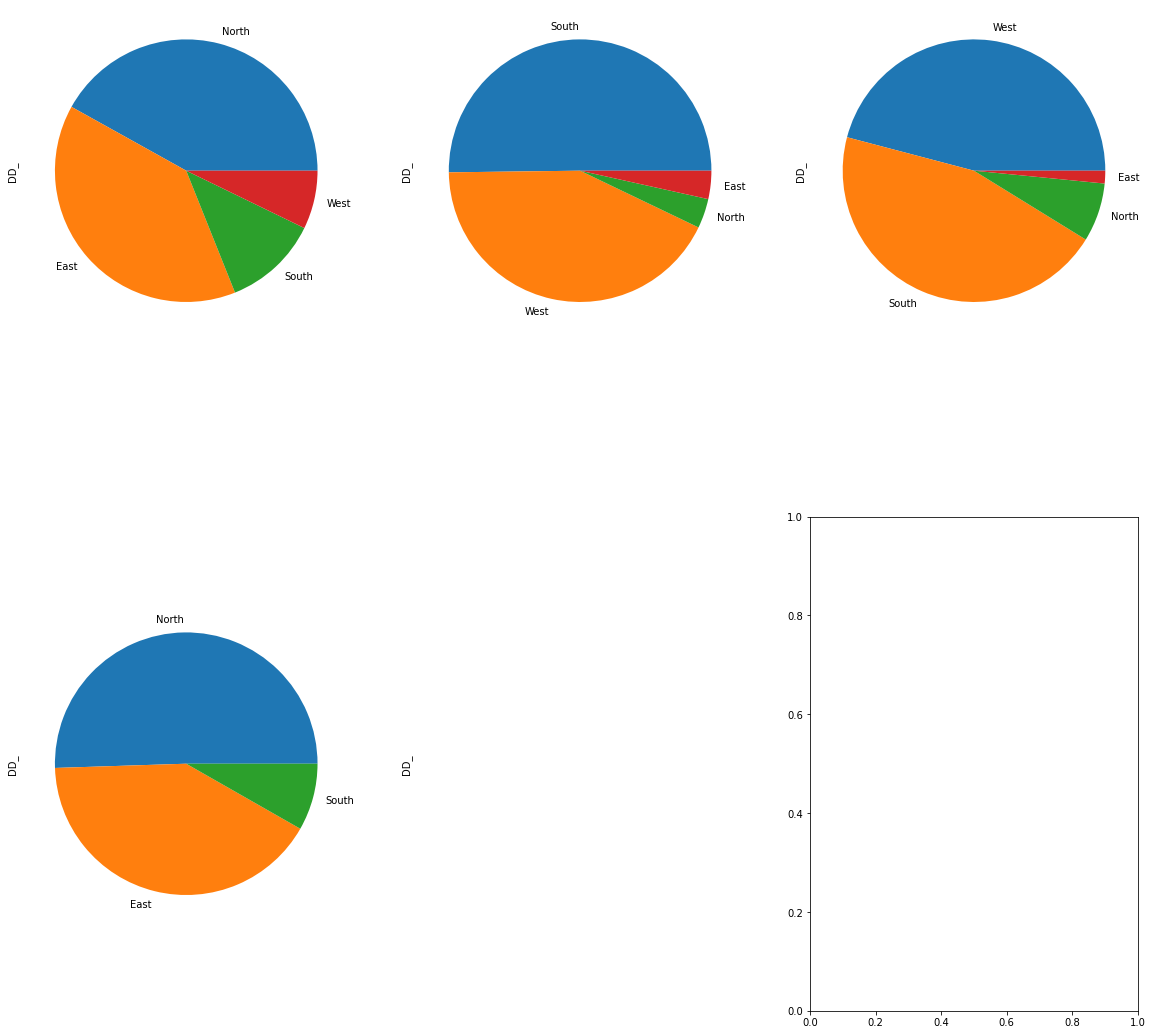

In [422]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

df_merged_cluster[df_merged_cluster['cluster_'] == 0]['DD_'].value_counts().plot(kind='pie', ax=axes[0,0])
df_merged_cluster[df_merged_cluster['cluster_'] == 1]['DD_'].value_counts().plot(kind='pie', ax=axes[0,1])
df_merged_cluster[df_merged_cluster['cluster_'] == 2]['DD_'].value_counts().plot(kind='pie', ax=axes[0,2])
df_merged_cluster[df_merged_cluster['cluster_'] == 3]['DD_'].value_counts().plot(kind='pie', ax=axes[1,0])
df_merged_cluster[df_merged_cluster['cluster_'] == 4]['DD_'].value_counts().plot(kind='pie', ax=axes[1,1])

<AxesSubplot:ylabel='T_cat'>

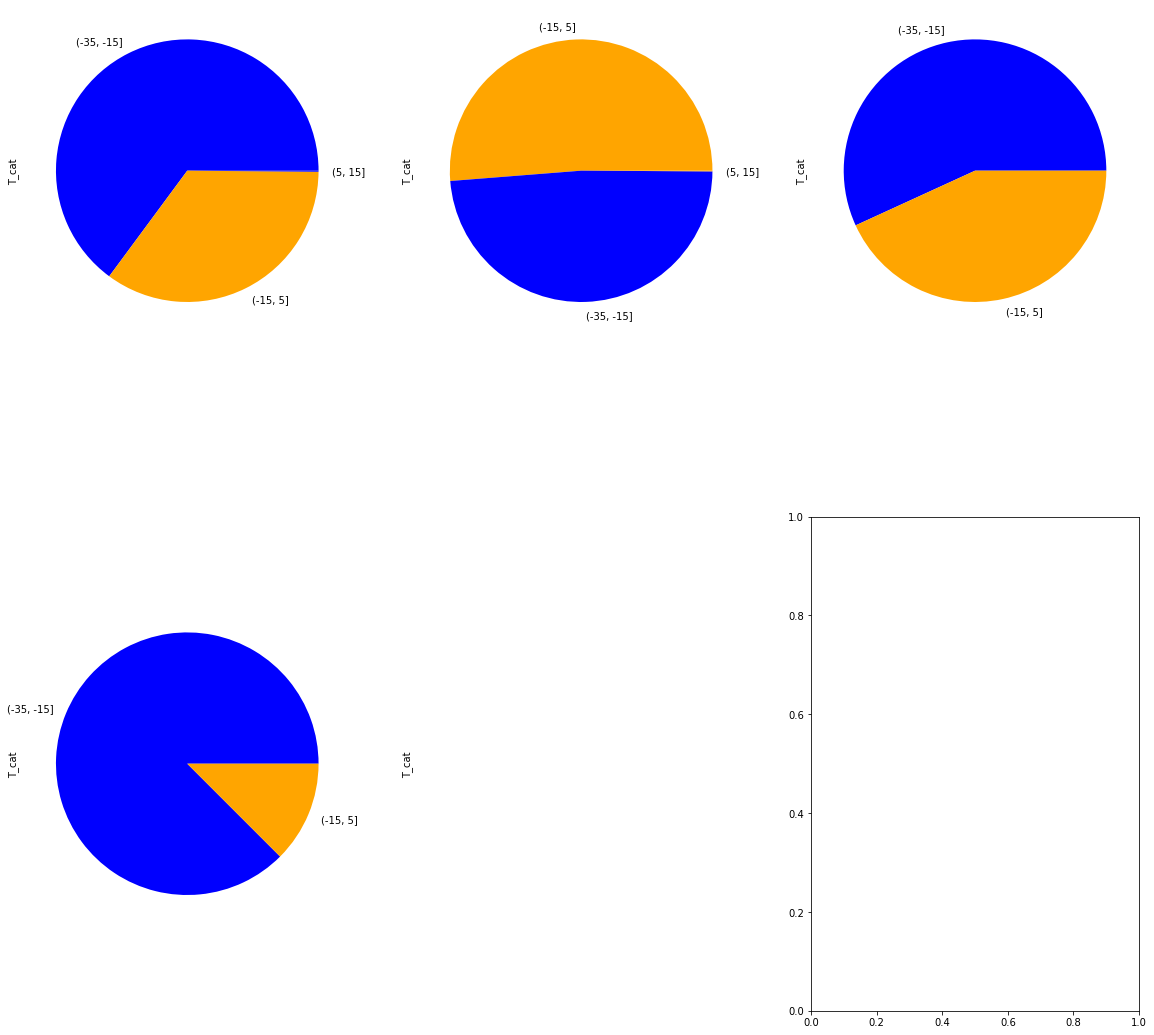

In [427]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
df_merged_cluster[df_merged_cluster['cluster_'] == 0]['T_cat'].value_counts().plot(kind='pie', ax=axes[0,0], colors=['blue', 'orange'])
df_merged_cluster[df_merged_cluster['cluster_'] == 1]['T_cat'].value_counts().plot(kind='pie', ax=axes[0,1], colors=['orange','blue'])
df_merged_cluster[df_merged_cluster['cluster_'] == 2]['T_cat'].value_counts().plot(kind='pie', ax=axes[0,2], colors=['blue', 'orange'])
df_merged_cluster[df_merged_cluster['cluster_'] == 3]['T_cat'].value_counts().plot(kind='pie', ax=axes[1,0], colors=['blue', 'orange'])
df_merged_cluster[df_merged_cluster['cluster_'] == 4]['T_cat'].value_counts().plot(kind='pie', ax=axes[1,1], colors=['blue', 'orange'])

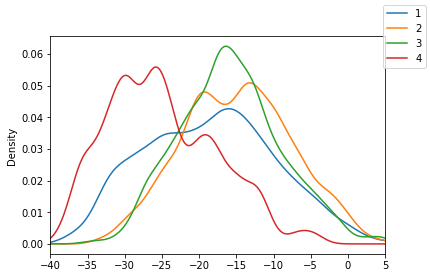

In [454]:
ax = plt.figure()
df_merged_cluster[df_merged_cluster['cluster_'] == 0]['T'].plot(kind='kde', bw_method=0.2, xlim=[-40,5])
df_merged_cluster[df_merged_cluster['cluster_'] == 1]['T'].plot(kind='kde', bw_method=0.2, xlim=[-40,5])
df_merged_cluster[df_merged_cluster['cluster_'] == 2]['T'].plot(kind='kde', bw_method=0.2, xlim=[-40,5])
df_merged_cluster[df_merged_cluster['cluster_'] == 3]['T'].plot(kind='kde', bw_method=0.2, xlim=[-40,5])
ax.legend(["1", "2", "3", "4"], loc="upper right")

In [361]:
df_merged_cluster[df_merged_cluster['cluster_'] == 0]['diff'].mean()

-1.446843434343433

In [349]:
df_merged_cluster[df_merged_cluster['cluster_'] == 1]['diff'].mean()

1.4510913500404181

In [350]:
df_merged_cluster[df_merged_cluster['cluster_'] == 2]['diff'].mean()

2.888085937500002

In [351]:
df_merged_cluster[df_merged_cluster['cluster_'] == 3]['diff'].mean()

-3.5865979381443296

In [352]:
df_merged_cluster[df_merged_cluster['cluster_'] == 0]['abs_diff'].mean()

1.446843434343433

In [353]:
df_merged_cluster[df_merged_cluster['cluster_'] == 1]['abs_diff'].mean()

1.4510913500404181

In [354]:
df_merged_cluster[df_merged_cluster['cluster_'] == 2]['abs_diff'].mean()

2.888085937500002

In [355]:
df_merged_cluster[df_merged_cluster['cluster_'] == 3]['abs_diff'].mean()

3.5865979381443296

In [379]:
# Добавить признаки разбить температуру на группы.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 391 entries, 2012-11-06 09:00:00 to 2021-02-28 09:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   T         391 non-null    float64
 1   Ff        391 non-null    float64
 2   N         391 non-null    float64
 3   Nh        391 non-null    float64
 4   Cl        391 non-null    int64  
 5   DD_       391 non-null    object 
 6   diff      391 non-null    float64
 7   abs_diff  391 non-null    float64
 8   DD_1      391 non-null    float64
 9   diff_1    391 non-null    float64
 10  Nh_1      391 non-null    float64
 11  cluster_  391 non-null    int32  
dtypes: float64(9), int32(1), int64(1), object(1)
memory usage: 38.2+ KB


In [435]:
df_merged_cluster[df_merged_cluster['cluster_'] == 3]['T'][df_merged_cluster['T'] <-35]

2012-12-15 00:00:00   -38.1
2018-01-23 09:00:00   -35.5
2018-01-25 03:00:00   -35.8
2018-01-25 06:00:00   -36.4
2018-01-25 09:00:00   -36.6
2018-12-25 03:00:00   -36.3
2021-01-03 03:00:00   -35.3
Name: T, dtype: float64

In [459]:
df_merged_cluster['cluster_'].value_counts().sort_values()

3      97
2     512
0     792
1    1237
Name: cluster_, dtype: int64

In [2]:
import tensorflow as tf

In [4]:
print(tf.__version__)

2.5.0


In [2]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2935 - accuracy: 0.9164
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1397 - accuracy: 0.9581
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1052 - accuracy: 0.9682
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0842 - accuracy: 0.9737
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.0701 - accuracy: 0.9770


[0.07007160037755966, 0.9769999980926514]

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [2]:
import nvidia_smi

nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

nvidia_smi.nvmlShutdown()

ModuleNotFoundError: No module named 'nvidia_smi'

#### разница омск - область

In [17]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8499 entries, 2012-11-01 00:00:00 to 2021-02-28 21:00:00
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T           8499 non-null   float64
 1   T_a         8499 non-null   float64
 2   DD          8499 non-null   object 
 3   Ff          8499 non-null   float64
 4   N           8491 non-null   float64
 5   Nh          6727 non-null   float64
 6   Cl          6727 non-null   object 
 7   Po          8496 non-null   float64
 8   U           8488 non-null   float64
 9   Ch          3019 non-null   object 
 10  Cm          5181 non-null   object 
 11  H           6739 non-null   object 
 12  RRR         2141 non-null   object 
 13  DD_         8499 non-null   object 
 14  diff        8499 non-null   float64
 15  abs_diff    8499 non-null   float64
 16  T_kal       8488 non-null   float64
 17  T_sher      8494 non-null   float64
 18  T_sar       6675 non-null   floa

In [5]:
df_merged_nn = df_merged[~df_merged['T_sar'].isnull()]
df_merged_nn = df_merged[~df_merged['T_sher'].isnull()]
df_merged_nn = df_merged[~df_merged['T_kal'].isnull()]
df_merged_nn = df_merged[~df_merged['three_mean'].isnull()]

In [61]:
# <= -25
v = df_merged_nn[df_merged_nn['T'] <= -20].groupby('DD_', as_index=False)[['diff_3', 'abs_diff_3']].mean()
# df_merged_nn[df_merged_nn['abs_diff_3'] >= 1].groupby('DD_', as_index=False)[['diff_3', 'abs_diff_3']].mean()

In [62]:
v = v.rename(columns={'DD_': 'Направление', 'diff_3': 'разница', 'abs_diff_3': 'абс.разн.'})
v.replace({'Calm': 'Штиль', 'East': 'Восточный', 'North': 'Северный', 'South': 'Южный', 'West': 'Западный'})

,Направление,разница,абс.разн.
0,Штиль,1.395667,1.685333
1,Восточный,1.122424,1.342788
2,Северный,0.585998,0.969104
3,Южный,1.602217,1.913378
4,Западный,1.668254,1.801832


In [26]:
# -15
df_merged_nn[df_merged_nn['T'] <= -15].groupby('DD', as_index=False)[['diff_3', 'abs_diff_3']].mean()

,DD,diff_3,abs_diff_3
0,"Ветер, дующий с востока",0.664368,1.040000
1,"Ветер, дующий с востоко-северо-востока",0.977507,1.234959
2,"Ветер, дующий с востоко-юго-востока",1.248634,1.368852
3,"Ветер, дующий с запада",1.209524,1.371429
4,"Ветер, дующий с западо-северо-запада",1.267836,1.549708
5,"Ветер, дующий с западо-юго-запада",1.280247,1.416543
6,"Ветер, дующий с севера",0.330314,0.810266
7,"Ветер, дующий с северо-востока",0.830037,1.289377
8,"Ветер, дующий с северо-запада",1.297407,1.481852
9,"Ветер, дующий с северо-северо-востока",0.667544,0.924561


Text(0.5, 0, 'разница температур (℃)')

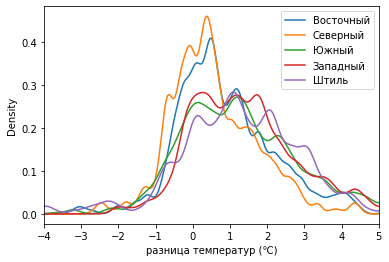

In [64]:
fig, ax = plt.subplots()
temp_b = -15
df_merged_nn[(df_merged_nn['DD_'] == 'East') & (df_merged_nn['T'] <= temp_b)]['diff_3'].plot.kde(bw_method=0.1, xlim=(-5,5))
df_merged_nn[(df_merged_nn['DD_'] == 'North') & (df_merged_nn['T'] <= temp_b)]['diff_3'].plot.kde(bw_method=0.1, xlim=(-5,5))
df_merged_nn[(df_merged_nn['DD_'] == 'South') & (df_merged_nn['T'] <= temp_b)]['diff_3'].plot.kde(bw_method=0.1, xlim=(-5,5))
df_merged_nn[(df_merged_nn['DD_'] == 'West') & (df_merged_nn['T'] <= temp_b)]['diff_3'].plot.kde(bw_method=0.1, xlim=(-5,5))
df_merged_nn[(df_merged_nn['DD_'] == 'Calm') & (df_merged_nn['T'] <= temp_b)]['diff_3'].plot.kde(bw_method=0.1, xlim=(-5,5))
# ax.legend(["East", "North", "South", "West", "Calm"])
ax.legend(["Восточный", "Северный", "Южный", "Западный", "Штиль"])
ax.set_xlim([-4, 5])
plt.xlabel('разница температур (℃)')

In [92]:
data_agg = df_merged_nn[(df_merged_nn['T'] <= 30) & (df_merged_nn['Po'] <= 750)]
print(len(data_agg.index))
data_agg.groupby('DD_', as_index=False)[['diff_3', 'abs_diff_3']].mean()

1456


,DD_,diff_3,abs_diff_3
0,Calm,0.942857,1.161905
1,East,0.163248,0.569516
2,North,0.140100,0.648872
3,South,0.225633,0.674257
4,West,0.416900,0.770629


#### предсказание

In [263]:
df_merged_nn = df_merged_nn[df_merged_nn['abs_diff_3'] > 0.5]

In [264]:
df_merged_nn['Cl'] = df_merged_nn['Cl'].fillna(0)
df_merged_nn['Ch'] = df_merged_nn['Ch'].fillna(0)
df_merged_nn['Cm'] = df_merged_nn['Cm'].fillna(0)
df_merged_nn['H'] = df_merged_nn['H'].fillna(0)
df_merged_nn['H'] = df_merged_nn['H'].fillna(0)
df_merged_nn['RRR'] = df_merged_nn['RRR'].fillna(0)

In [265]:
train_data = df_merged_nn['2012':'2019-03']
# train_data = train_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a', 'T_kal', 'T_sher', 'T_sar', 'three_mean'])
train_data = train_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_kal', 'T_sher', 'T_sar', 'three_mean'])

eval_data = df_merged_nn['2019-11':]
# eval_data = eval_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a', 'T_kal', 'T_sher', 'T_sar', 'three_mean'])
eval_data = eval_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_kal', 'T_sher', 'T_sar', 'three_mean'])
train_labels = df_merged_nn['2012':'2019-03']['diff_3']

In [266]:
model9 = CatBoostRegressor(iterations=1000, # {'depth': 10, 'l2_leaf_reg': 5, 'iterations': 1000, 'learning_rate': 0.3}
                           task_type="GPU",
                           devices='0:1',
                         depth=10,
                         l2_leaf_reg=5,
                         learning_rate=0.3)
cat_cols = ['DD','DD_', 'Cl', 'Cm','Ch', 'H', 'RRR']

In [267]:
model9.fit(train_data,
          train_labels,
          verbose=False,
         cat_features=cat_cols)

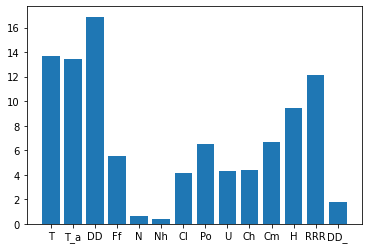

In [268]:
plt.bar(train_data.columns, model9.get_feature_importance())
plt.show()

In [269]:
eps = 1e-6
preds = model9.predict(eval_data)
df_merged_w_preds1 = df_merged_nn['2019-11':].copy()
df_merged_w_preds1['diff_p'] = pd.Series(preds, index=df_merged_w_preds1.index)
df_merged_w_preds1['error'] = abs(df_merged_w_preds1['diff_3'] - df_merged_w_preds1['diff_p'])
df_merged_w_preds1['error rel'] = abs(df_merged_w_preds1['error']/df_merged_w_preds1['diff_3'] + 1e-6)
df_merged_w_preds1['error rel lg'] = np.log(abs(df_merged_w_preds1['error']/df_merged_w_preds1['diff_3'] + 1e-6)*10 +1)
df_merged_w_preds1['mape'] = df_merged_w_preds1.apply(mean_absolute_percentage_error, axis=1)
df_merged_w_preds1[['diff_3', 'diff_p', 'error', 'error rel', 'error rel lg']]

,diff_3,diff_p,error,error rel,error rel lg
2019-11-01 00:00:00,0.866667,0.154844,0.711823,0.821335,2.220653
2019-11-01 03:00:00,-0.933333,-0.850743,0.082591,0.088489,0.633869
2019-11-01 06:00:00,-1.833333,0.317759,2.151093,1.173322,2.544214
2019-11-01 09:00:00,-1.800000,-0.232883,1.567117,0.870620,2.272764
2019-11-02 12:00:00,-0.533333,0.073477,0.606811,1.137769,2.515896
...,...,...,...,...,...
2021-02-27 12:00:00,2.933333,1.902575,1.030758,0.351396,1.507175
2021-02-27 15:00:00,0.966667,2.002863,1.036196,1.071928,2.461235
2021-02-27 18:00:00,-2.200000,1.415252,3.615252,1.643295,2.858362
2021-02-27 21:00:00,2.366667,2.383547,0.016881,0.007134,0.068907


In [368]:
df_merged_w_preds1['error'].mean()

1.217646299790814

In [369]:
abs(df_merged_w_preds1['diff_3']).mean()

1.7779721412374472

In [278]:
df_merged_w_preds1['error'][df_merged_w_preds1['abs_diff_3'] > 1].mean()

1.452793347030402

In [299]:
abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['abs_diff_3'] > 1]).mean()

2.3992283950617295

In [370]:
df_merged_w_preds1['error'][df_merged_w_preds1['T'] <-25].mean()

1.1540751759767067

In [371]:
abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['T'] <-25]).mean()

2.3704260651629085

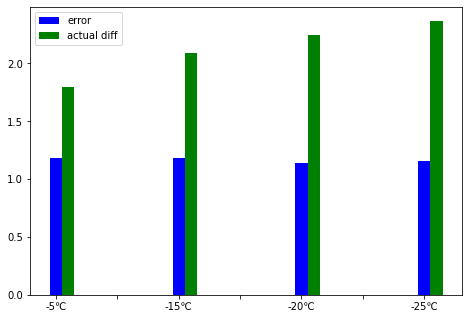

In [402]:
# bar_plot
e1 = df_merged_w_preds1['error'][df_merged_w_preds1['T'] <-5].mean()
ad1 = abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['T'] <-5]).mean()

e2 = df_merged_w_preds1['error'][df_merged_w_preds1['T'] <-15].mean()
ad2 = abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['T'] <-15]).mean()

e3 = df_merged_w_preds1['error'][df_merged_w_preds1['T'] <-20].mean()
ad3 = abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['T'] <-20]).mean()

e4 = df_merged_w_preds1['error'][df_merged_w_preds1['T'] <-25].mean()
ad4 = abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['T'] <-25]).mean()

data1 = [e1, e2, e3, e4]
data2 = [ad1, ad2, ad3, ad4]

labels = ['', '-5℃', '', '-15℃','', '-20℃','', '-25℃']
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticklabels(labels)
ax.bar(X + 0.00, data1, color = 'b', width = 0.1)
ax.bar(X + 0.1, data2, color = 'g', width = 0.1)
ax.legend(['error','actual diff'])

In [310]:
display(df_merged_w_preds1['error'][df_merged_w_preds1['DD_'] == 'Calm'].mean())
display(abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['DD_'] == 'Calm']).mean())

1.5817275042882084

2.1942386831275713

In [320]:
display(df_merged_w_preds1['error'][df_merged_w_preds1['DD_'] == 'North'].mean())
display(abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['DD_'] == 'North']).mean())

1.0670764355195888

1.389230769230769

In [319]:
display(df_merged_w_preds1['error'][df_merged_w_preds1['DD_'] == 'West'].mean())
display(abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['DD_'] == 'West']).mean())

1.305734006449023

1.8735416666666675

In [318]:
display(df_merged_w_preds1['error'][df_merged_w_preds1['DD_'] == 'South'].mean())
display(abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['DD_'] == 'South']).mean())

1.1486784921548774

1.8386983289357965

In [317]:
display(df_merged_w_preds1['error'][df_merged_w_preds1['DD_'] == 'West'].mean())
display(abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['DD_'] == 'West']).mean())

1.305734006449023

1.8735416666666675

In [330]:
df_merged_w_preds1[df_merged_w_preds1['error']  >= 2]['DD'].value_counts()

Ветер, дующий с юго-юго-запада            33
Ветер, дующий с юга                       28
Ветер, дующий с юго-запада                26
Штиль, безветрие                          24
Ветер, дующий с западо-юго-запада         15
Ветер, дующий с востока                    7
Ветер, дующий с севера                     7
Ветер, дующий с востоко-северо-востока     7
Ветер, дующий с северо-северо-запада       6
Ветер, дующий с запада                     5
Ветер, дующий с юго-востока                5
Ветер, дующий с северо-востока             5
Ветер, дующий с юго-юго-востока            4
Ветер, дующий с востоко-юго-востока        2
Ветер, дующий с северо-северо-востока      1
Ветер, дующий с западо-северо-запада       1
Name: DD, dtype: int64

In [238]:
df_merged_w_preds1[df_merged_w_preds1['error']  <= 0.1]

,T,T_a,DD,Ff,N,Nh,Cl,Po,U,Ch,...,T_sher,T_sar,three_mean,diff_3,abs_diff_3,diff_p,error,error rel,error rel lg,mape
2019-11-02 00:00:00,-4.8,-5.0,"Ветер, дующий с западо-юго-запада",4.0,40.0,40.0,Кучево-дождевые волокнистые (часто с наковальн...,746.5,67.0,"Перистых, перисто-кучевых или перисто-слоистых...",...,-5.0,-4.4,-4.600000,-0.200000,0.200000,-0.245368,0.045368,0.226837,1.184292,222.683824
2019-11-02 18:00:00,-3.7,-4.0,"Ветер, дующий с запада",3.0,100.0,100.0,Кучево-дождевые волокнистые (часто с наковальн...,758.4,62.0,0,...,-4.1,-4.2,-3.933333,0.233333,0.233333,0.285383,0.052050,0.223070,1.172700,4.872380
2019-11-03 00:00:00,-6.9,-8.0,"Ветер, дующий с юго-запада",1.0,0.0,NaN,0,762.3,73.0,0,...,-9.8,-8.6,-7.800000,0.900000,0.900000,0.888038,0.011962,0.013293,0.124804,19.269315
2019-11-04 06:00:00,-4.2,-4.0,"Ветер, дующий с северо-востока",2.0,100.0,40.0,"Слоисто-кучевые, образовавшиеся не из кучевых.",759.5,85.0,0,...,-3.7,-5.1,-4.833333,0.633333,0.633333,0.576796,0.056537,0.089271,0.638008,388.397930
2019-11-05 06:00:00,-11.3,-8.0,"Штиль, безветрие",0.0,0.0,NaN,0,758.9,87.0,0,...,-10.0,-13.2,-11.733333,0.433333,0.433333,0.515315,0.081981,0.189189,1.061909,115.615596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-18 21:00:00,-18.7,-18.0,"Ветер, дующий с востоко-северо-востока",7.0,100.0,100.0,Кучево-дождевые волокнистые (часто с наковальн...,744.4,84.0,0,...,-18.1,-19.1,-18.566667,-0.133333,0.133333,-0.202045,0.068711,0.515334,1.816996,71.136468
2021-02-19 03:00:00,-18.4,-18.0,"Ветер, дующий с северо-северо-востока",5.0,100.0,100.0,Кучево-дождевые волокнистые (часто с наковальн...,737.2,84.0,0,...,-18.1,-18.8,-18.366667,-0.033333,0.033333,0.035494,0.068827,2.064816,3.074920,108.873475
2021-02-23 18:00:00,-20.0,-20.0,"Ветер, дующий с востока",7.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",754.4,81.0,0,...,-18.6,-19.8,-19.700000,-0.300000,0.300000,-0.221067,0.078933,0.263107,1.289529,inf
2021-02-24 03:00:00,-16.8,-16.0,"Ветер, дующий с востоко-северо-востока",10.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",746.4,85.0,0,...,-15.1,-17.9,-16.766667,-0.033333,0.033333,-0.098552,0.065219,1.956572,3.023625,87.680947


In [249]:
winds = df_merged_w_preds1['DD'].unique()
winds

array(['Ветер, дующий с юго-востока', 'Ветер, дующий с юго-юго-запада',
       'Ветер, дующий с западо-юго-запада', 'Ветер, дующий с юго-запада',
       'Ветер, дующий с запада', 'Ветер, дующий с юга',
       'Штиль, безветрие', 'Ветер, дующий с северо-востока',
       'Ветер, дующий с востоко-северо-востока',
       'Ветер, дующий с северо-северо-востока',
       'Ветер, дующий с северо-запада',
       'Ветер, дующий с северо-северо-запада', 'Ветер, дующий с севера',
       'Ветер, дующий с юго-юго-востока',
       'Ветер, дующий с западо-северо-запада',
       'Ветер, дующий с востоко-юго-востока', 'Ветер, дующий с востока'],
      dtype=object)

In [342]:
actual_diff = []
labels = []
for wind in winds:
    print(wind)
    print('rows: ', len(df_merged_w_preds1['error'][df_merged_w_preds1['DD'] == wind].index))
    print('error: ', df_merged_w_preds1['error'][df_merged_w_preds1['DD'] == wind].mean())
    print('actual diff: ', abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['DD'] == wind]).mean())
    act_erorr = abs(df_merged_w_preds1['diff_3'][df_merged_w_preds1['DD'] == wind]).mean() - df_merged_w_preds1['error'][df_merged_w_preds1['DD'] == wind].mean()
    print('actual - error: ', act_erorr)
    actual_diff.append(act_erorr)
    labels.append(wind)

Ветер, дующий с юго-востока
rows:  43
error:  0.8449596056900054
actual diff:  1.479069767441861
actual - error:  0.6341101617518555
Ветер, дующий с юго-юго-запада
rows:  140
error:  1.2621397412435167
actual diff:  1.8261904761904766
actual - error:  0.5640507349469599
Ветер, дующий с западо-юго-запада
rows:  114
error:  0.9849576760232017
actual diff:  1.5602339181286549
actual - error:  0.5752762421054531
Ветер, дующий с юго-запада
rows:  135
error:  1.824951064619928
actual diff:  2.416049382716051
actual - error:  0.5910983180961229
Ветер, дующий с запада
rows:  58
error:  0.8781800524651376
actual diff:  1.2850574712643679
actual - error:  0.40687741879923023
Ветер, дующий с юга
rows:  133
error:  1.2882011725607745
actual diff:  2.0278195488721806
actual - error:  0.7396183763114061
Штиль, безветрие
rows:  81
error:  1.5817275042882084
actual diff:  2.1942386831275713
actual - error:  0.6125111788393629
Ветер, дующий с северо-востока
rows:  23
error:  1.0862382800359154
actual d

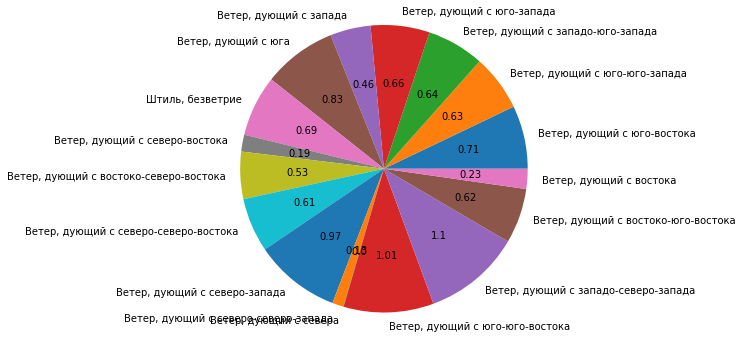

In [367]:
def values(val):
    return round(val*0.1, 2)

fig1, ax1 = plt.subplots()
fig1.set_size_inches(18.5/1.8, 10.5/1.8)
ax1.pie(actual_diff, labels=labels, autopct=values)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()